In [4]:
import pandas as pd
print(pd.__version__)


2.3.3


In [5]:
import pandas as pd

# Load the files
nodes = pd.read_csv("input/nodes.csv")
edges = pd.read_csv("input/edges.csv")

# Quick look
print("Nodes shape:", nodes.shape)
print("Node Type Counts:")
print(nodes['node_type'].value_counts())
print("Is_Hubb Counts:")
print(nodes['is_hub'].value_counts())
print("Edges shape:", edges.shape)
print("Edge Type Counts:")
print(edges['edge_type'].value_counts())

"""
print("\nSample nodes:")
print(nodes.head())
print("\nSample edges:")
print(edges.head()) 
""" 



Nodes shape: (8298, 5)
Node Type Counts:
node_type
ingredient    6653
compound      1645
Name: count, dtype: int64
Is_Hubb Counts:
is_hub
no_hub    6237
food      1561
hub        416
drug        84
Name: count, dtype: int64
Edges shape: (147179, 4)
Edge Type Counts:
edge_type
ingr-ingr     111355
ingr-fcomp     35440
ingr-dcomp       384
Name: count, dtype: int64


'\nprint("\nSample nodes:")\nprint(nodes.head())\nprint("\nSample edges:")\nprint(edges.head()) \n'

### Focus on ingredient relationships

In [6]:
ingr_ingr_edges = edges[edges["edge_type"] == "ingr-ingr"]
print(ingr_ingr_edges.shape)
ingr_ingr_edges.head()


(111355, 4)


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


### Merge nodes + edges
- removes non-ingredient entries since ingr-ingr-edges only has ingr 

In [7]:
merged = (
    ingr_ingr_edges
    .merge(nodes, left_on="id_1", right_on="node_id", how="left")
    .rename(columns={"node_type": "node_type_1", "is_hub": "is_hub_1", "name": "name_1"})
    .drop(columns=["node_id", "id"])  # drop the merged ID column to prevent conflict
    .merge(nodes, left_on="id_2", right_on="node_id", how="left")
    .rename(columns={"node_type": "node_type_2", "is_hub": "is_hub_2", "name": "name_2"})
    .drop(columns=["node_id", "id"])  # drop again
)


print(merged.shape)
merged.head()


(111355, 10)


,id_1,id_2,score,edge_type,name_1,node_type_1,is_hub_1,name_2,node_type_2,is_hub_2
0,5063,6083,0.337742,ingr-ingr,prawn,ingredient,hub,squid,ingredient,hub
1,244,4620,0.093855,ingr-ingr,baby_leek,ingredient,no_hub,parsley,ingredient,hub
2,2253,6753,0.107870,ingr-ingr,extra_virgin_olive_oil,ingredient,no_hub,vin_santo,ingredient,no_hub
3,2813,6228,0.092569,ingr-ingr,garlic_powder,ingredient,no_hub,swanson_chicken_broth,ingredient,no_hub
4,3016,6314,0.123897,ingr-ingr,green_onion,ingredient,no_hub,taco_blend_cheese,ingredient,no_hub


# sanity check 
- everything should be ingredients

In [8]:
merged['node_type_2'].value_counts()
merged['is_hub_2'].value_counts()

# check for duplicates
merged.duplicated().sum() #none

# check for missing values
merged.isnull().sum()
merged_clean = merged.dropna(subset=["name_1", "name_2"]).reset_index(drop=True)
merged_clean.isnull().sum()
print(merged_clean.shape)

(111325, 10)


In [ ]:
print(merged_clean["score"].describe())

count    111325.000000
mean          0.197229
std           0.107045
min           0.000008
25%           0.119846
50%           0.187351
75%           0.258916
max           0.858234
Name: score, dtype: float64


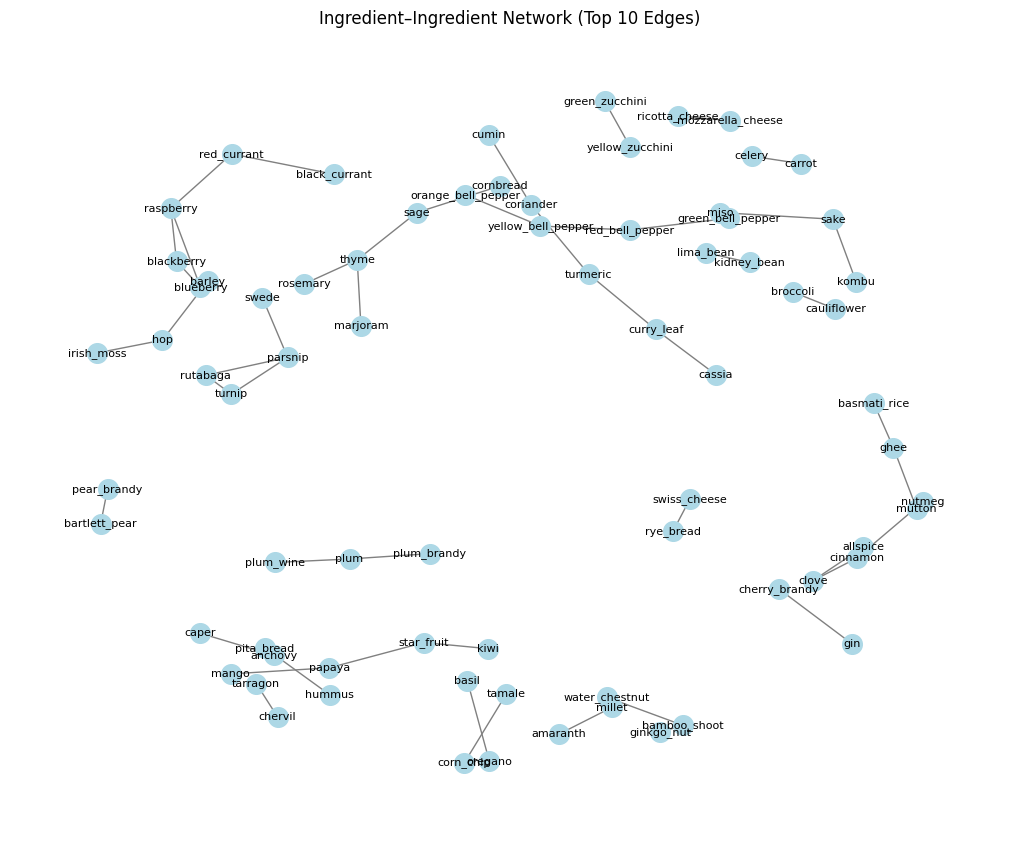

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter rows where both ingredient is a hub
hub_df = merged_clean[
    (merged_clean["is_hub_1"] == "hub") & (merged_clean["is_hub_2"] == "hub")
]

# Create graph with top edges
subset = hub_df.nlargest(50, "score")
G = nx.from_pandas_edgelist(subset, "name_1", "name_2", edge_attr="score")

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)
nx.draw(
    G, pos, with_labels=True, node_color="lightblue", edge_color="gray",
    node_size=200, font_size=8

)       
plt.title("Ingredient–Ingredient Network (Top 10 Edges)")
plt.show()
